In [45]:

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


# Download latest version of the dataset and save the path in which it was downloaded to
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")  



In [46]:
#Read in the heart data
heart_data = pd.read_csv(f"{path}/heart.csv")

heart_data.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [47]:
#First the one hot encoder needs to be applied to the columns
#ChestPainType, RestingECG, ST_Slope
to_encode = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
new_encoder = OneHotEncoder( sparse_output=False)
encoded_heart = new_encoder.fit_transform(heart_data[to_encode])
encoded_heart = pd.DataFrame(encoded_heart, columns=new_encoder.get_feature_names_out(to_encode), index=heart_data.index)
print(encoded_heart)

heart_data = pd.concat([heart_data, encoded_heart], axis=1)
heart_data = heart_data.drop(columns=to_encode)
#As a sanity check to make sure all values are numeric
heart_data = heart_data.astype(float)
heart_data.head()


     Sex_F  Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
0      0.0    1.0                0.0                1.0                0.0   
1      1.0    0.0                0.0                0.0                1.0   
2      0.0    1.0                0.0                1.0                0.0   
3      1.0    0.0                1.0                0.0                0.0   
4      0.0    1.0                0.0                0.0                1.0   
..     ...    ...                ...                ...                ...   
913    0.0    1.0                0.0                0.0                0.0   
914    0.0    1.0                1.0                0.0                0.0   
915    0.0    1.0                1.0                0.0                0.0   
916    1.0    0.0                0.0                1.0                0.0   
917    0.0    1.0                0.0                0.0                1.0   

     ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  Resti

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49.0,160.0,180.0,0.0,156.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37.0,130.0,283.0,0.0,98.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48.0,138.0,214.0,0.0,108.0,1.5,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54.0,150.0,195.0,0.0,122.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [48]:
#Next the training splits need to be made
target = heart_data['HeartDisease']
x_data = heart_data.drop(columns="HeartDisease")

x_train, x_test, y_train, y_test = train_test_split(x_data, target)


In [49]:
#Now apply the standard scaler to the x_train data

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [43]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = GradientBoostingClassifier(n_estimators=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
learning_rates = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for lern in tqdm(np.arange(0.05, 1.0, 0.05)):
        classy = GradientBoostingClassifier(n_estimators=10, learning_rate=lern)
        learning_rates.append(lern)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(learning_rates, testing_scores)
plt.scatter(learning_rates, training_scores)
plt.show()

plt.clf()
plt.scatter(learning_rates, training_accuracy)
plt.scatter(learning_rates, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for split in tqdm(range(2, 10)):
        classy = GradientBoostingClassifier(n_estimators=10, learning_rate=0.15, min_samples_split=split)
        splits.append(split)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(splits, testing_scores)
plt.scatter(splits, training_scores)
plt.show()

plt.clf()
plt.scatter(splits, training_accuracy)
plt.scatter(splits, testing_accuracy)
plt.show()

learning_rates = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

for lern in tqdm(np.arange(0.05, 0.5, 0.05)):
        classy = GradientBoostingClassifier(n_estimators=10, min_samples_leaf=lern)
        learning_rates.append(lern)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(learning_rates, testing_scores)
plt.scatter(learning_rates, training_scores)
plt.show()

plt.clf()
plt.scatter(learning_rates, training_accuracy)
plt.scatter(learning_rates, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

 77%|███████▋  | 76/99 [00:56<00:33,  1.46s/it]

  0%|          | 0/99 [00:00<?, ?it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
  2%|▏         | 2/99 [00:00<00:06, 14.39it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecat

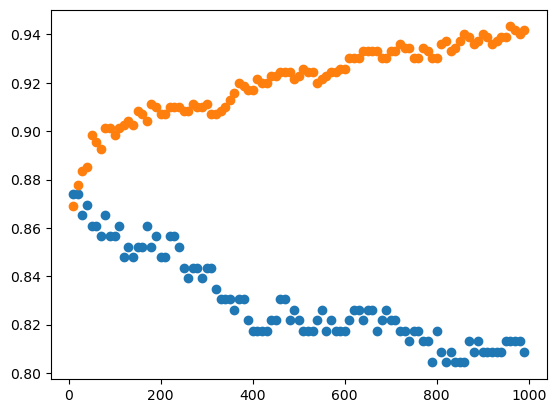

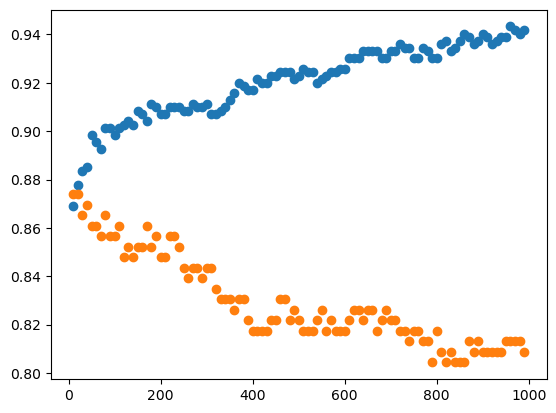

  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
 33%|███▎      | 3/9 [00:00<00:00, 22.55it/s]c:\Users\Eza\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated

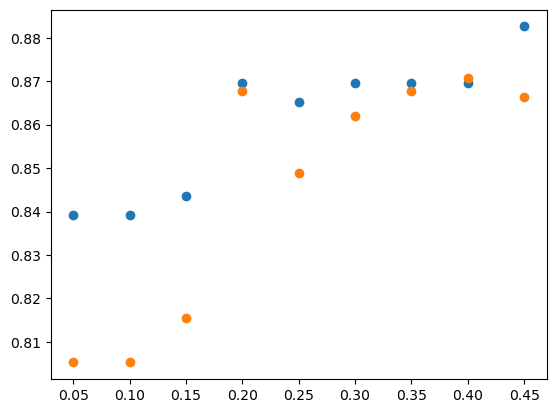

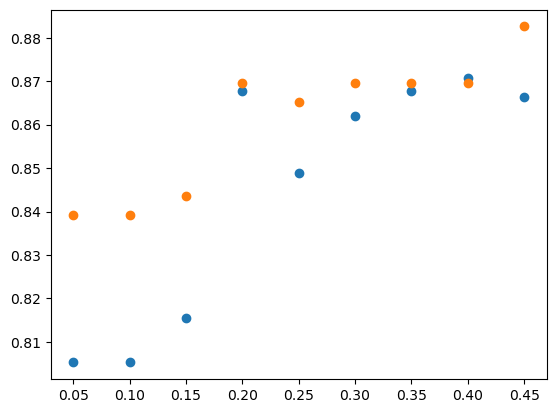

In [38]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = AdaBoostClassifier(n_estimators=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
learning_rates = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for lern in tqdm(np.arange(0.05, 0.5, 0.05)):
        classy = AdaBoostClassifier(n_estimators=10, learning_rate=lern)
        learning_rates.append(lern)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(learning_rates, testing_scores)
plt.scatter(learning_rates, training_scores)
plt.show()

plt.clf()
plt.scatter(learning_rates, training_accuracy)
plt.scatter(learning_rates, testing_accuracy)
plt.show()

#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []


100%|██████████| 99/99 [01:38<00:00,  1.00it/s]


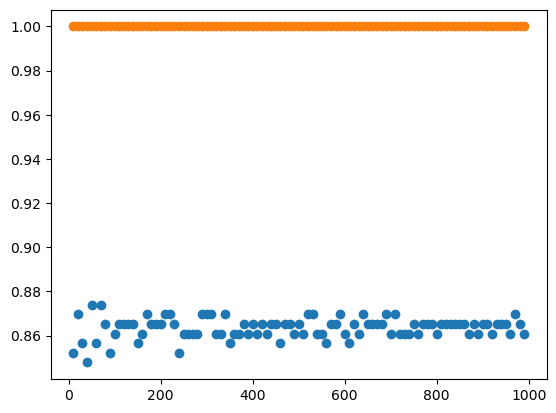

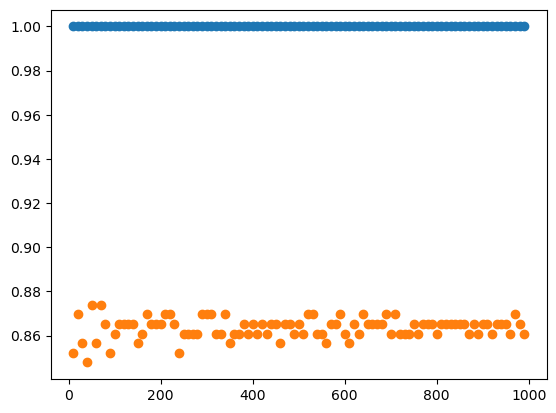

100%|██████████| 8/8 [00:00<00:00, 29.75it/s]


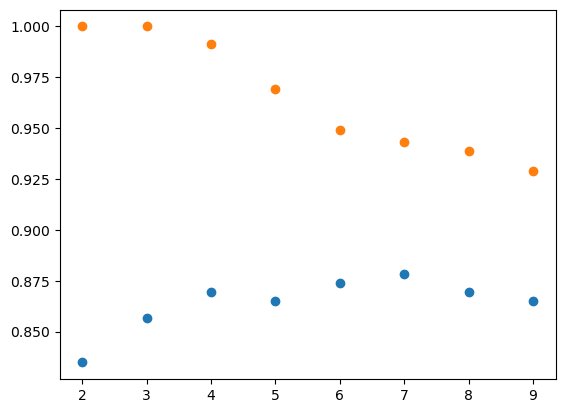

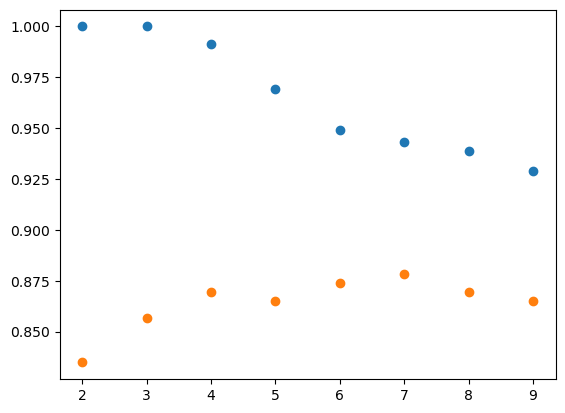

In [39]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = ExtraTreesClassifier(n_estimators=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()



#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for split in tqdm(range(2, 10)):
        classy = ExtraTreesClassifier(n_estimators=10, min_samples_split=split)
        splits.append(split)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(splits, testing_scores)
plt.scatter(splits, training_scores)
plt.show()

plt.clf()
plt.scatter(splits, training_accuracy)
plt.scatter(splits, testing_accuracy)
plt.show()

100%|██████████| 99/99 [01:58<00:00,  1.20s/it]


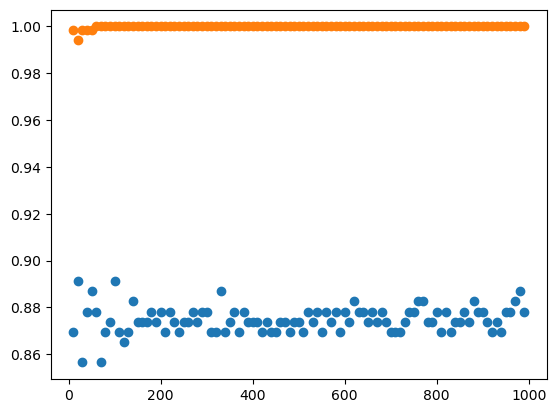

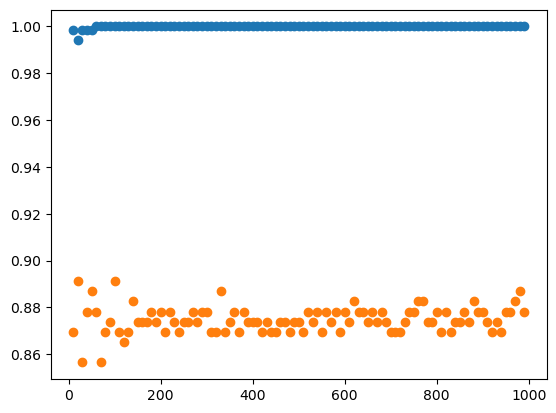

100%|██████████| 8/8 [00:00<00:00, 26.85it/s]


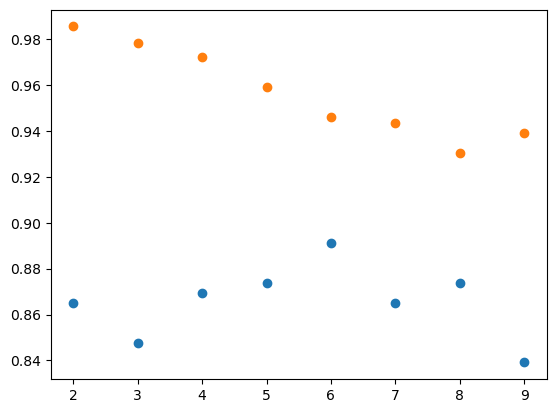

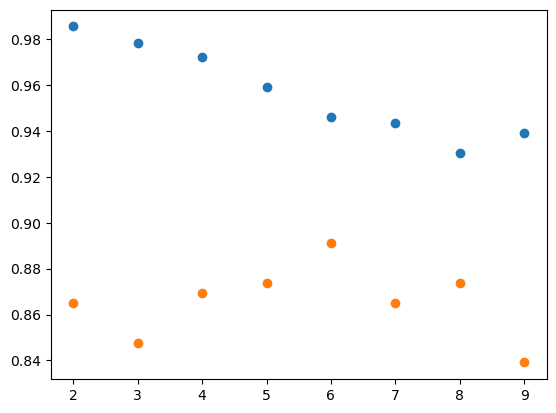

In [40]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = RandomForestClassifier(n_estimators=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()


#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for split in tqdm(range(2, 10)):
        classy = RandomForestClassifier(n_estimators=10, min_samples_split=split)
        splits.append(split)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(splits, testing_scores)
plt.scatter(splits, training_scores)
plt.show()

plt.clf()
plt.scatter(splits, training_accuracy)
plt.scatter(splits, testing_accuracy)
plt.show()

100%|██████████| 99/99 [00:34<00:00,  2.90it/s]


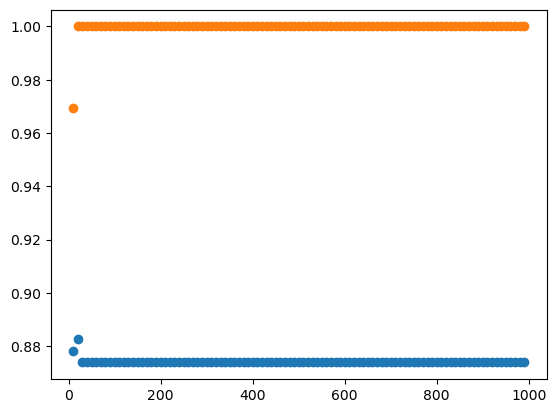

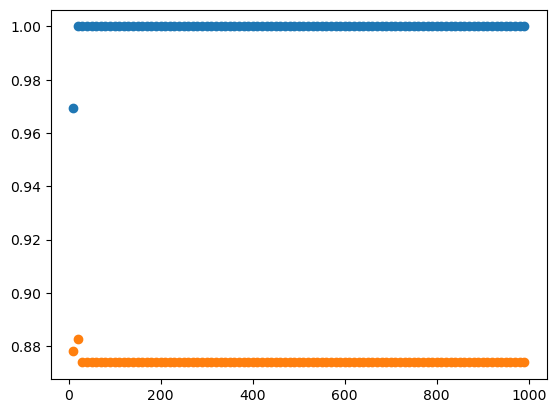

  0%|          | 0/8 [00:00<?, ?it/s]


TypeError: HistGradientBoostingClassifier.__init__() got an unexpected keyword argument 'min_samples_split'

In [41]:
#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
n_estimators = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for n_est in tqdm(range(10, 1000, 10)):
        classy = HistGradientBoostingClassifier(max_leaf_nodes=n_est)
        n_estimators.append(int(n_est))
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(n_estimators, testing_scores)
plt.scatter(n_estimators, training_scores)
plt.show()

plt.clf()
plt.scatter(n_estimators, training_accuracy)
plt.scatter(n_estimators, testing_accuracy)
plt.show()


#Now we can start training the classifier
#We want to see ideal parameters for the gradient boosting classifier
splits = []
training_scores = []
testing_scores = []
training_accuracy = []
testing_accuracy = []

#Use tqdm to track progress and see if snacking is acceptable
for split in tqdm(range(2, 10)):
        classy = HistGradientBoostingClassifier(max_leaf_nodes=10, min_samples_split=split)
        splits.append(split)
        classy.fit(x_train_scaled, y_train)
        testing_scores.append(classy.score(x_test_scaled, y_test))
        training_scores.append(classy.score(x_train_scaled, y_train))
        y_pred_train = classy.predict(x_train_scaled)
        y_pred_test = classy.predict(x_test_scaled)
        testing_accuracy.append(confusion_matrix(y_test, y_pred_test))
        training_accuracy.append(confusion_matrix(y_train, y_pred_train))
        
plt.scatter(splits, testing_scores)
plt.scatter(splits, training_scores)
plt.show()

plt.clf()
plt.scatter(splits, training_accuracy)
plt.scatter(splits, testing_accuracy)
plt.show()